In [2]:
import geopandas as gpd
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, LineString, Polygon, MultiPolygon
from shapely import wkt
import folium
import ast
import pickle

In [2]:
# lendo os arquivos .shp
paradas = gpd.read_file('../../databases/paradas/paradas.shp')
linhas = gpd.read_file('../../databases/linhas/Linhas.shp')

In [7]:
# Qual sistemas estamos?
# acessando o atributo crs
paradas.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
# Convertendo, paradas de onibus, de Sistema de coordenadas EPSG:31983 para EPSG:4326
paradas_df = paradas.to_crs("EPSG:4326")
paradas_df

,parada,descricao,situacao,estrutura_,tipo,geometry
0,6710,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76791 -15.91132)
1,6711,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76793 -15.91160)
2,6712,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76900 -15.91399)
3,6713,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76933 -15.91454)
4,6827,Residencial Vitoria,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76832 -15.90857)
...,...,...,...,...,...,...
5452,1163,NUCLEO RURAL RODEADOR - LADO OPOSTO ESCOLA ROD...,ATIVA,ACOSTAMENTO OU BAIA,Tipo C,POINT (-48.10282 -15.67575)
5453,1164,NUCLEO RURAL RODEADOR - EM FRENTE ESCOLA RODEA...,ATIVA,ACOSTAMENTO OU BAIA,Tipo C,POINT (-48.10322 -15.67570)
5454,1166,ANTES DA ENTRADA PARA A DF 445 NORTE - KM 7 DF...,ATIVA,SEM ESTRUTURA,Tipo C,POINT (-48.14080 -15.66765)
5455,1159,LADO OPOSTO A ENTRADA DA RADIOBRAS E DF 220 DF...,ATIVA,SEM ESTRUTURA,Habitual,POINT (-48.14358 -15.63395)


In [4]:
# Convertendo, linhas de onibus, de Sistema de coordenadas EPSG:31983 para EPSG:4326
linhas_df = linhas.to_crs("EPSG:4326")
linhas_df

,id,linha,nome,sentido,faixa_tari,tarifa,situacao,bacia,tipo_da_li,situacao_d,geometry
0,14832,0.018,PARANOÁ PARQUE / W3 NORTE (VIA PONTE JK),IDA,METROPOLITANA 2,5.5,Ativa,2,Rodoviária,T,"LINESTRING (-47.78134 -15.76050, -47.78154 -15..."
1,14833,0.018,PARANOÁ PARQUE / W3 NORTE (VIA PONTE JK),VOLTA,METROPOLITANA 2,5.5,Ativa,2,Rodoviária,T,"LINESTRING (-47.90742 -15.73629, -47.90757 -15..."
2,13249,100.2,Paranoá (Paranoá Parque) / Rodoviária do Plano...,VOLTA,METROPOLITANA 2,5.5,Ativa,2,Rodoviária,T,"LINESTRING (-47.88207 -15.79409, -47.88201 -15..."
3,10696,0.946,Vicente Pires / Rodoviária do Plano Piloto (EIXO),IDA,METROPOLITANA 2,5.5,Ativa,5,Rodoviária,T,"LINESTRING (-48.05308 -15.79527, -48.05308 -15..."
4,15435,0.373,Samambaia Norte (2 Avenida) / Rodoviária do Pl...,IDA,METROPOLITANA 2,5.5,Ativa,3,Rodoviária,T,"LINESTRING (-48.15060 -15.88391, -48.15030 -15..."
...,...,...,...,...,...,...,...,...,...,...,...
1303,14091,372.5,Samambaia Norte (1ª Avenida) / Taguacenter,CIRCULAR,METROPOLITANA 1,3.8,Ativa,3,Rodoviária,T,"LINESTRING (-48.15060 -15.88391, -48.15127 -15..."
1304,13208,506.2,Sobradinho I-II / Catingueiro,VOLTA,RURAL 3,5.5,Ativa,6,Rodoviária,T,"LINESTRING (-47.94140 -15.54974, -47.94136 -15..."
1305,13209,506.2,Sobradinho I-II / Catingueiro,IDA,RURAL 3,5.5,Ativa,6,Rodoviária,T,"LINESTRING (-47.78577 -15.64976, -47.78599 -15..."
1306,14100,0.050,Samambaia Norte (QN 423-425) / Taguacenter (Sa...,CIRCULAR,METROPOLITANA 1,3.8,Ativa,3,Rodoviária,T,"LINESTRING (-48.15060 -15.88391, -48.15127 -15..."


In [5]:
# Escolhendo uma linestring de uma rota de onibus 
linestringGama = linhas_df[linhas_df['linha']=='0.205']
linestringGama

,id,linha,nome,sentido,faixa_tari,tarifa,situacao,bacia,tipo_da_li,situacao_d,geometry
140,14844,0.205,Gama Sul - Leste / Setor M Norte (Samdu / Come...,VOLTA,METROPOLITANA 2,5.5,Ativa,2,Rodoviária,T,"LINESTRING (-48.11046 -15.79485, -48.11016 -15..."
468,14847,0.205,Gama Sul - Leste / Setor M Norte (Samdu / Come...,IDA,METROPOLITANA 2,5.5,Ativa,2,Rodoviária,T,"LINESTRING (-48.06688 -16.02025, -48.06701 -16..."


In [50]:
# Plotar a linha de onibus escolhida com folium
import folium

# Criar um mapa inicial
m = folium.Map(location=[-15.76050, -47.78134], zoom_start=10)

# Obter o objeto LineString a partir da coluna "geometry" do DataFrame
linestring1 = linestringGama.geometry.iloc[1] # Ida
linestring2 = linestringGama.geometry.iloc[0] # Volta

# Converter as coordenadas do Linestring para o formato que o Folium espera (latitude, longitude)
lat_lon_coordsIda = [(lat1, lon1) for lon1, lat1 in linestring1.coords]
lat_lon_coordsVolta = [(lat2, lon2) for lon2, lat2 in linestring2.coords]


# Adicionar o Linestring ao mapa como uma polilinha (linha poligonal)

# Plotando a ida
folium.PolyLine(locations=lat_lon_coordsIda, color='blue', tooltip=linestringGama['linha'].iloc[1]+ ' ' + linestringGama['sentido'].iloc[1]).add_to(m)

# Plotando a volta
folium.PolyLine(locations=lat_lon_coordsVolta, color='red', tooltip=linestringGama['linha'].iloc[0]+ ' ' + linestringGama['sentido'].iloc[0]).add_to(m)

# Mostrar o mapa
m

In [7]:
# Plotar TODAS as paradas de onibus de uma rota

# Obter o objeto LineString a partir da coluna "geometry" do DataFrame
linestring = linestringGama.geometry.iloc[0] 

def aproximar_coordenadas(coord):
    return round(coord, 3)

# Lista para armazenar as paradas encontradas
paradas_encontradas = []

# Iterar sobre os pontos de paradas e verificar se estão contidos na Linestring
for idx, ponto_parada in paradas_df.iterrows():
    ponto = ponto_parada["geometry"]
    ponto_aproximado = Point(aproximar_coordenadas(ponto.x), aproximar_coordenadas(ponto.y))
    linestring_aproximada = LineString([Point(aproximar_coordenadas(x), aproximar_coordenadas(y)) for x, y in linestring.coords])
    if linestring_aproximada.contains(ponto_aproximado):
        paradas_encontradas.append(ponto_parada)

# Criar um novo GeoDataFrame com as paradas encontradas
gdf_paradas_encontradas = gpd.GeoDataFrame(paradas_encontradas, crs='EPSG:4326')

for idx, ponto_parada in gdf_paradas_encontradas.iterrows():
    lat, lon = ponto_parada["geometry"].y, ponto_parada["geometry"].x
    folium.Marker([lat, lon], popup=ponto_parada['parada']).add_to(m)


In [8]:
m

In [27]:
gdf_paradas_encontradas

,parada,descricao,situacao,estrutura_,tipo,geometry
300,1900,QUADRA 05 CASA 74 ST. LESTE,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-48.05312 -16.00349)
302,6364,EM FRENTE AO INSTITUTO FEDERAL DE BRASÍLIA - C...,ATIVA,SEM ESTRUTURA,Padrão,POINT (-48.05407 -15.99521)
309,1891,ENTRE QUADRAS INDUSTRIAIS 07/04 ST. INDUST.,ATIVA,ACOSTAMENTO OU BAIA,Canalete 90,POINT (-48.05422 -16.00124)
310,1892,QI 07 AREA DA SLU PATIO ST. INDUST.,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-48.05347 -16.00320)
312,1909,QUADRA 44 - COMERCIO LOCAL SHIS LESTE,ATIVA,ACOSTAMENTO OU BAIA,Canalete 90,POINT (-48.05790 -15.99874)
...,...,...,...,...,...,...
4967,5092,FEIRA POPULAR ALA 2 BOX 19/20 MN 1- AV HELIO P...,ATIVA,SEM ESTRUTURA,Placa,POINT (-48.07670 -15.80607)
4969,5106,ENTRE A QNH 3 E QNH 4 MN 1- AV HELIO PRATES,ATIVA,SEM ESTRUTURA,Placa,POINT (-48.07685 -15.80569)
5066,5013,QNE 1 - ENXOVAIS VERDES MARES (MICROLINS) COME...,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-48.06284 -15.81726)
5092,7801,SETOR M NORTE - AV PRINCIPAL - QNM 36 - CONJUN...,ATIVA,NaN,Tipo C,POINT (-48.09678 -15.80377)


In [34]:
## Validando se as paradas podem ser transformadas em nós de um Grafo na ordem em que estão no DataFrane

# Criar um mapa inicial
m = folium.Map(location=[-15.76050, -47.78134], zoom_start=10)

## Priemiras e últimas paradas de gdf_paradas_encontradas
nos_paradas = ([1900, 6364, 1891, 1892, 1909, 5092, 5106, 5013, 7801, 5070])

for idx, ponto_parada in gdf_paradas_encontradas.iterrows():
    # print(type(ponto_parada['parada']))
    if int(ponto_parada['parada']) in nos_paradas:
        lat, lon = ponto_parada["geometry"].y, ponto_parada["geometry"].x
        folium.Marker([lat, lon], popup=ponto_parada['parada']).add_to(m)

# Mostrar o mapa
m

In [36]:
# Ordenar o DataFrame em ordem crescente com base na coluna 'parada'
gdf_paradas_encontradas_sorted = gdf_paradas_encontradas.sort_values(by='parada')

# Mostrar o DataFrame organizado
gdf_paradas_encontradas_sorted

,parada,descricao,situacao,estrutura_,tipo,geometry
4864,1856,FRENTE ENTRADA PARA O COND. PARK DO GAMA DF - 480,ATIVA,ACOSTAMENTO OU BAIA,Padrão,POINT (-48.04386 -15.98654)
309,1891,ENTRE QUADRAS INDUSTRIAIS 07/04 ST. INDUST.,ATIVA,ACOSTAMENTO OU BAIA,Canalete 90,POINT (-48.05422 -16.00124)
310,1892,QI 07 AREA DA SLU PATIO ST. INDUST.,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-48.05347 -16.00320)
4723,1895,QI 7 LT 220 ST. INDUST.,ATIVA,SEM ESTRUTURA,Placa,POINT (-48.05401 -16.01528)
300,1900,QUADRA 05 CASA 74 ST. LESTE,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-48.05312 -16.00349)
...,...,...,...,...,...,...
814,7918,DF 001 - PASSARELA DE PEDESTRE - BAL?O DE ACES...,ATIVA,NaN,Tipo C,POINT (-48.05487 -15.89873)
815,7919,DF 001 - PASSARELA DE PEDESTRE - BAL?O DE ACES...,ATIVA,NaN,Tipo C,POINT (-48.05487 -15.89873)
816,7920,DF 001 - PASSARELA DE PEDESTRE - BAL?O DE ACES...,ATIVA,NaN,Tipo C,POINT (-48.05487 -15.89873)
1440,7921,DF 001 - CONDOMINIO PARQUE DO RIACHO 04/03,ATIVA,NaN,Tipo C,POINT (-48.05622 -15.89456)


In [37]:
## Validando se as paradas podem ser transformadas em nós de um Grafo na ordem em que estão no DataFrane

# Criar um mapa inicial
m = folium.Map(location=[-15.76050, -47.78134], zoom_start=10)

nos_paradas = ([1856, 1891, 1892, 1895, 1900, 7918, 7919, 7920, 7921, 7982])

for idx, ponto_parada in gdf_paradas_encontradas_sorted.iterrows():
    if int(ponto_parada['parada']) in nos_paradas:
        lat, lon = ponto_parada["geometry"].y, ponto_parada["geometry"].x
        folium.Marker([lat, lon], popup=ponto_parada['parada']).add_to(m)

# Mostrar o mapa
m

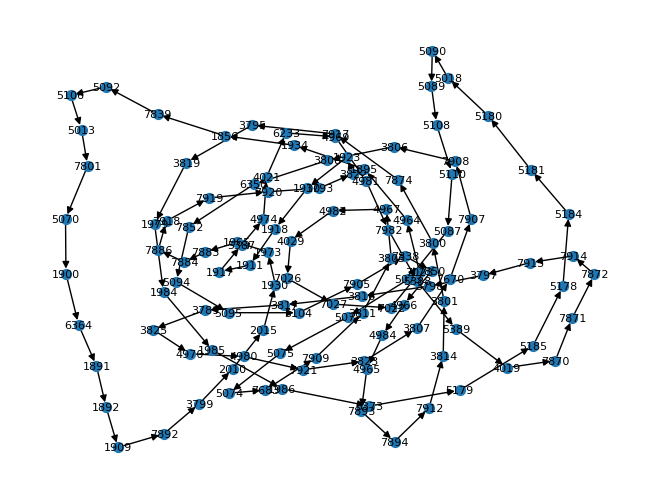

In [35]:
# Função para calcular a distância euclidiana entre dois pontos
def distance_between_points(origem, destino):
    return origem.distance(destino)

# Criar um Grafo Direcional vazio
grafo = nx.DiGraph()

# Adicionar nós ao grafo
for idx, row in gdf_paradas_encontradas_sorted.iterrows():
    grafo.add_node(row['parada'], pos=row['geometry'])  # 'row['parada'] como identificador do nó e 'geometry' para obter o ponto.

# Adicionar arestas orientadas entre os nós
num_paradas = len(gdf_paradas_encontradas_sorted)
for i in range(num_paradas):
    # Obter as coordenadas de origem e destino
    origem = gdf_paradas_encontradas_sorted.iloc[i]['parada']
    destino = gdf_paradas_encontradas_sorted.iloc[(i + 1) % num_paradas]['parada']

    origem_coords = grafo.nodes[origem]['pos']
    destino_coords = grafo.nodes[destino]['pos']

    # Calcular a distância entre as paradas
    distancia = distance_between_points(origem_coords, destino_coords)

    # Adicionar aresta orientada
    grafo.add_edge(origem, destino, distancia=distancia)

# Obter as posições dos nós usando o layout padrão do NetworkX
pos = nx.spring_layout(grafo, seed=42)

# Desenhar o grafo
nx.draw(grafo, pos, with_labels=True, node_size=50, font_size=8)


# Mostrar o desenho do grafo
plt.show()

In [25]:
# Criar um mapa
m = folium.Map(location=[-15.9, -48.0], zoom_start=12)

# Adicionar as paradas como marcadores no mapa
for parada, data in grafo.nodes(data=True):
    lat, lon = data['pos'].y, data['pos'].x
    folium.Marker([lat, lon], popup=f'Parada {parada}').add_to(m)

# Adicionar as arestas ao mapa
for origem, destino, data in grafo.edges(data=True):
    origem_coords = (grafo.nodes[origem]['pos'].y, grafo.nodes[origem]['pos'].x) 
    destino_coords = (grafo.nodes[destino]['pos'].y, grafo.nodes[destino]['pos'].x)
    folium.PolyLine([origem_coords, destino_coords], color='blue', weight=2).add_to(m)

m

### Criando um DataFrame de todos os pontos de uma Linestring

In [6]:
# Obter o objeto LineString a partir da coluna "geometry" do DataFrame
linestring = linestringGama.geometry.iloc[1] # Sentido 'IDA' 
    
pontosNaLinestring_list = []

for long, lat in linestring.coords:    
    ponto = Point(long, lat)
    pontosNaLinestring_list.append([ponto])

pontosNaLinestring_df = gpd.GeoDataFrame(pontosNaLinestring_list, columns=['geometry'])
pontosNaLinestring_df

,geometry
0,POINT (-48.06688 -16.02025)
1,POINT (-48.06701 -16.02043)
2,POINT (-48.06710 -16.02062)
3,POINT (-48.06707 -16.02088)
4,POINT (-48.06840 -16.02292)
...,...
622,POINT (-48.11071 -15.79461)
623,POINT (-48.11072 -15.79465)
624,POINT (-48.11071 -15.79469)
625,POINT (-48.11068 -15.79471)


### Trabalhando com as Linestrings compostas apenas de Paradas de Ônibus

In [4]:
# lendo arquivo das linhas de ônibus após tratamento 
linhasTratadasIda = pd.read_csv("../../databases/luiz_dataset/paradas_linestrings_ida.csv", converters={'parada': pd.eval})
linhasTratadasIda = linhasTratadasIda.drop('Unnamed: 0', axis=1)
linhasTratadasIda

,linha,parada
0,0.018,"[[-15.747487243955707, -47.89600866323914, 351..."
1,0.946,"[[-15.80778852625573, -47.96642705712294, 2256..."
2,0.373,"[[-15.866555379423424, -47.96504713913905, 605..."
3,503.300,"[[-15.638937404577504, -47.82260762728512, 491..."
4,531.100,"[[-15.638937404577504, -47.82260762728512, 491..."
...,...,...
482,0.844,"[[-15.884075085352835, -48.129561044093, 4228]..."
483,0.172,"[[-15.866555379423424, -47.96504713913905, 605..."
484,805.600,"[[-15.867119301987762, -48.02312295895697, 534..."
485,506.200,"[[-15.638004360182045, -47.821280315734576, 48..."


In [5]:
# lendo arquivo das linhas de ônibus após tratamento 
linhasTratadasVolta = pd.read_csv("../../databases/luiz_dataset/paradas_linestrings_volta.csv", converters={'parada': pd.eval})
linhasTratadasVolta = linhasTratadasVolta.drop('Unnamed: 0', axis=1)
linhasTratadasVolta

,linha,parada
0,0.018,"[[-15.767293, -47.788723, 7557], [-15.77012499..."
1,100.200,"[[-15.858748568353112, -47.92771717852002, 250..."
2,531.100,"[[-15.638937404577504, -47.82260762728512, 491..."
3,396.200,"[[-15.866860500781998, -47.96679853983349, 605..."
4,0.851,"[[-15.866860500781998, -47.96679853983349, 605..."
...,...,...
472,0.844,"[[-15.880512000000007, -48.122922, 7626], [-15..."
473,0.845,"[[-15.898521115410318, -48.12156066472963, 411..."
474,0.172,"[[-15.866860500781998, -47.96679853983349, 605..."
475,805.600,"[[-15.86461088791683, -48.02439841365415, 5335..."


### Encontrar a ordem que as paradas de ônibus ocorrem na Linestring

In [8]:
LIMITE_PROXIMIDADE = 0.0002

paradasEncontradasNaLinestring = []

for lat, long, id in linhasTratadasIda.parada.iloc[186]:
    paradaLinestring = Point(long, lat)
    for index, pontoLinestring in pontosNaLinestring_df.iterrows():
        pontoNaLinestring = pontoLinestring['geometry']
        distancia = paradaLinestring.distance(pontoNaLinestring)
        if distancia <= LIMITE_PROXIMIDADE:
            paradasEncontradasNaLinestring.append([index, id, paradaLinestring])
            break # Encerrar loop depois de encontrar uma parada próxima ao ponto da Linestring
        

paradasNaLinestring_df = gpd.GeoDataFrame(paradasEncontradasNaLinestring, columns=["index", "parada", 'geometry'])

In [9]:
paradasNaLinestring_df

,index,parada,geometry
0,306,7918,POINT (-48.05487 -15.89873)
1,306,7919,POINT (-48.05487 -15.89873)
2,306,7920,POINT (-48.05487 -15.89873)
3,147,1923,POINT (-48.05321 -16.01658)
4,112,1916,POINT (-48.05581 -16.02453)
5,414,4976,POINT (-48.03187 -15.86770)
6,406,4975,POINT (-48.02949 -15.87220)
7,433,6232,POINT (-48.04034 -15.85193)
8,364,4019,POINT (-48.04366 -15.87422)
9,221,7908,POINT (-48.02603 -15.95959)


In [54]:
paradasNaLinestring_df_ordenado = paradasNaLinestring_df.sort_values(by='index')
paradasNaLinestring_df_ordenado

,index,parada,geometry
15,50,1979,POINT (-48.06090 -16.03706)
16,59,3373,POINT (-48.05909 -16.04082)
4,112,1916,POINT (-48.05581 -16.02453)
3,147,1923,POINT (-48.05321 -16.01658)
30,179,1934,POINT (-48.03623 -15.98041)
9,221,7908,POINT (-48.02603 -15.95959)
27,227,3810,POINT (-48.03080 -15.95394)
28,229,6354,POINT (-48.03315 -15.95118)
14,280,3819,POINT (-48.05159 -15.90897)
13,280,7917,POINT (-48.05161 -15.90897)


In [51]:
# Plotas as paradas ordenadas no Folium

for idx, ponto_parada in paradasNaLinestring_df_ordenado.iterrows():
    lat, lon = ponto_parada["geometry"].y, ponto_parada["geometry"].x
    folium.Marker([lat, lon], popup=ponto_parada['index']).add_to(m)

m

### Criando Grafo Direcional a partir do Data Frame das paradas ordenadas de uma linha de ônibus no sentido IDA

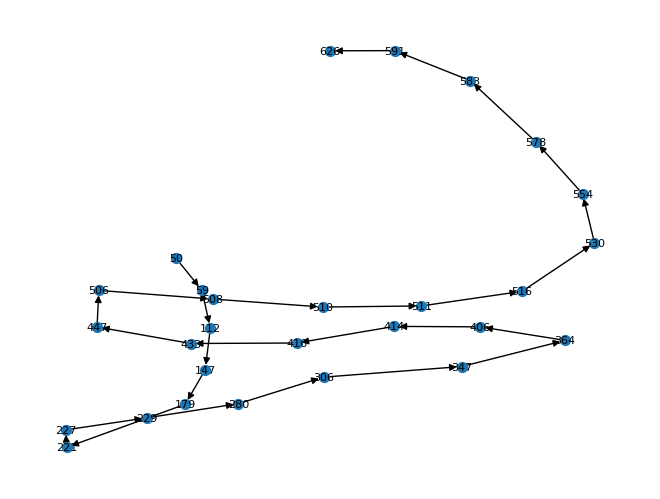

In [61]:
# Função para calcular a distância euclidiana entre dois pontos
def distance_between_points(origem, destino):
    return origem.distance(destino)

# Criar um Grafo Direcional vazio
grafo = nx.DiGraph()

# Adicionar nós ao grafo
for idx, row in paradasNaLinestring_df_ordenado.iterrows():
    grafo.add_node(row['index'], pos=row['geometry'])  # 'row['index'] como identificador do nó e 'geometry' para obter o ponto.

# Adicionar arestas orientadas entre os nós
num_paradas = len(paradasNaLinestring_df_ordenado)
for i in range(num_paradas-1):
    # Obter as coordenadas de origem e destino
    origem = paradasNaLinestring_df_ordenado.iloc[i]['index']
    destino = paradasNaLinestring_df_ordenado.iloc[i + 1]['index']

    if origem == destino:
        continue

    origem_coords = grafo.nodes[origem]['pos']
    destino_coords = grafo.nodes[destino]['pos']

    # Calcular a distância entre as paradas
    distancia = distance_between_points(origem_coords, destino_coords)

    # Adicionar aresta orientada
    grafo.add_edge(origem, destino, distancia=distancia)

# Obter as posições dos nós usando o layout padrão do NetworkX
pos = nx.spring_layout(grafo, seed=42)

# Desenhar o grafo
nx.draw(grafo, pos, with_labels=True, node_size=50, font_size=8)


# Mostrar o desenho do grafo
plt.show()

In [64]:
# Adicionar as paradas como marcadores no mapa
for parada, data in grafo.nodes(data=True):
    lat, lon = data['pos'].y, data['pos'].x
    folium.Marker([lat, lon], popup=f'Parada {parada}').add_to(m)

# Adicionar as arestas ao mapa
for origem, destino, data in grafo.edges(data=True):
    origem_coords = (grafo.nodes[origem]['pos'].y, grafo.nodes[origem]['pos'].x) 
    destino_coords = (grafo.nodes[destino]['pos'].y, grafo.nodes[destino]['pos'].x)
    folium.PolyLine([origem_coords, destino_coords], color='black', weight=2).add_to(m)

m

### Novo Tratamento das Linhas e Paradas

- As paradas agora estão ordenadas, baseadas na ordem da rota do onibus
- As linhas de ônibus do sentido 'IDA' e 'VOLTA' foram unidas, baseadas no número da linha


In [ ]:
# Ler os dados
paradas_onibus_df = pd.read_csv('Lucas/paradas_onibus.csv')
linhas_df = pd.read_csv('Lucas/Linhas.csv')

# Converter para GeoDataFrames
paradas_onibus_df['geometry'] = paradas_onibus_df['geo_ponto_rede_pto'].apply(wkt.loads)
linhas_df['geometry'] = linhas_df['geo_linhas_lin'].apply(wkt.loads)

gdf_paradas_onibus = gpd.GeoDataFrame(paradas_onibus_df, geometry='geometry')
gdf_linhas = gpd.GeoDataFrame(linhas_df, geometry='geometry')

# Inicializar um dicionário para armazenar as linhas e suas paradas associadas
linhas_e_paradas = {}

# Limite de distância para considerar uma parada como "associada" a uma linha (em metros)
limite_distancia = 20  # Ajuste conforme necessário

# Loop para cada linha
for idx_line, line in gdf_linhas.iterrows():
    # Usando somente o valor da coluna "linha" como identificador
    linha_id = f"{line['linha']}"
    
    if linha_id not in linhas_e_paradas:
        linhas_e_paradas[linha_id] = []
    
    # Loop para cada parada de ônibus
    for idx_stop, stop in gdf_paradas_onibus.iterrows():
        # Calcular a distância entre a parada e a linha
        distancia = line['geometry'].distance(stop['geometry'])
        
        # Se a distância for menor do que o limite, associar a parada à linha
        if distancia < limite_distancia:
            coords = list(stop['geometry'].coords)[0]
            # Calcular a "posição projetada" ao longo da linha para a ordenação
            position_along_line = line['geometry'].project(Point(coords))
            linhas_e_paradas[linha_id].append((coords, position_along_line, stop['parada']))

    # Ordenar as paradas com base na "posição projetada"
    linhas_e_paradas[linha_id] = sorted(linhas_e_paradas[linha_id], key=lambda x: x[1])

# Converter o dicionário em um DataFrame
df_linhas_e_paradas = pd.DataFrame([(key, [[coords, id] for coords, _, id in value]) for key, value in linhas_e_paradas.items()], columns=['Linha_Sentido', 'Paradas'])

# Salvar o DataFrame como um arquivo CSV
df_linhas_e_paradas.to_csv('linhas_e_paradas_ordenadas.csv', index=False)

# Gerando o folium com alguma linha de teste

Aqui pegamos uma linha no arquivo csv e plotamos suas paradas no folium

In [20]:
# Carregar o DataFrame salvo anteriormente
df_linhas_e_paradas = pd.read_csv('uniao_linhas_e_paradas_ordenadas.csv')

# Filtrar as paradas da linha 813.2 no sentido de "IDA"
linha_813_2_ida_volta = df_linhas_e_paradas[df_linhas_e_paradas['Linha_Sentido'] == 813.2]['Paradas'].iloc[0]

# Convertendo a string para uma lista de tuplas
linha_813_2_ida_volta = ast.literal_eval(linha_813_2_ida_volta)
# linha_813_2_ida_volta


# Criar um GeoDataFrame temporário
gdf_temp = gpd.GeoDataFrame(
    {'geometry': [Point(xy) for xy, _ in linha_813_2_ida_volta]},
    crs="EPSG:31983"  # Substitua pelo CRS apropriado se for diferente
)

# # Reprojetar para WGS 84
gdf_temp = gdf_temp.to_crs(epsg=4326)

# # Inicializar o mapa do Folium (ajuste as coordenadas iniciais conforme necessário)
m = folium.Map(location=[-15.7942, -47.8825], zoom_start=12)

# # Adicionar as paradas ao mapa
for idx, point in gdf_temp.iterrows():
    coords = list(point['geometry'].coords)[0]
    folium.Marker([coords[1], coords[0]], popup=f'Parada {idx}').add_to(m)

m

## Grafo de todas as linhas 

In [6]:
# Carregar o DataFrame salvo anteriormente
df_linhas_e_paradas = pd.read_csv('uniao_linhas_e_paradas_ordenadas.csv')

# Criar um grafo Direcional
GrafoLinhasOnibusDF = nx.DiGraph()

def geraDataFrameParadas(row):
    # Convertendo a string para uma lista de tuplas
    paradasDaLinha = ast.literal_eval(row['Paradas'])

    # Criar um GeoDataFrame temporário
    gdf_temp = gpd.GeoDataFrame(
        {'geometry': [Point(xy) for xy, _ in paradasDaLinha]},
        crs="EPSG:31983"  # Substitua pelo CRS apropriado se for diferente
    )

    # Adicionar coluna dos identificadores das paradas
    gdf_temp['idParada'] = [id for xy, id in paradasDaLinha]

    ## Reprojetar para WGS 84
    gdf_temp = gdf_temp.to_crs(epsg=4326)

    return gdf_temp


# Função para calcular a distância euclidiana entre dois pontos
def distance_between_points(origem, destino):
    return origem.distance(destino)


def adicionaArestaNoGrafo(idNoOrigem, idNoDestino, linha):
    global GrafoLinhasOnibusDF

    # Nós iguais no mesmo Data Frame
    if idNoOrigem == idNoDestino:
        return
    
    origem_coords = GrafoLinhasOnibusDF.nodes[idNoOrigem]['coords']
    destino_coords = GrafoLinhasOnibusDF.nodes[idNoDestino]['coords']
    # Calcular a distância entre as paradas
    distancia = distance_between_points(origem_coords, destino_coords)
    
    # Adicionar aresta orientada
    GrafoLinhasOnibusDF.add_edge(idNoOrigem, idNoDestino, dist=distancia, linha=linha)


def integraParadasDaLinhaNoGrafo(paradas_df, linha):
    global GrafoLinhasOnibusDF

    tamanho_df = len(paradas_df)
    for idx, row in paradas_df.iterrows():
        if row['idParada'] not in GrafoLinhasOnibusDF:
            GrafoLinhasOnibusDF.add_node(row['idParada'], coords=row['geometry'])
        if idx > 0:
            origem = paradas_df.iloc[(idx-1)]['idParada']
            destino = paradas_df.iloc[idx]['idParada']
            adicionaArestaNoGrafo(origem, destino, linha)

    primeiro_no = paradas_df.iloc[0]['idParada']
    ultimo_no = paradas_df.iloc[tamanho_df-1]['idParada']
    adicionaArestaNoGrafo(ultimo_no, primeiro_no, linha)

    
# Percorrendo todas as linhas de ônibus
for idx, row in df_linhas_e_paradas.iterrows():
    paradas_df = geraDataFrameParadas(row)
    linha = row['Linha_Sentido']
    integraParadasDaLinhaNoGrafo(paradas_df, linha)
    print(GrafoLinhasOnibusDF.nodes(data=True))


### Salvar o Grafo com Pickle

In [7]:
import pickle

# Salvar o grafo em um arquivo usando pickle
with open('grafo_linhas.grafo', 'wb') as f:
    pickle.dump(GrafoLinhasOnibusDF, f)

### Carregando Grafo Salvo


In [ ]:
# Ler o grafo de um arquivo usando pickle
with open('grafo_linhas.grafo', 'rb') as f:
    GrafoLinhasOnibusDF = pickle.load(f)

### Plotando com o Folium

In [ ]:
# Plotar o grafo
pos = {i: (data['coords'].x, data['coords'].y) for i, data in GrafoLinhasOnibusDF.nodes(data=True)}
nx.draw(GrafoLinhasOnibusDF, pos, with_labels=True, node_color='red', font_weight='0', node_size=200, font_size=11)
plt.show()

In [24]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import folium
import pandas as pd

# Filtrando a linestring apenas pelas linhas de onibus de ida
linestringLinhas = linhas[linhas['sentido']=='IDA']
# linestringLinhas = linestringLinhas.to_crs('EPSG:4326')

# Criando um pandasdataframe para armazenar todas as nossas linhas
df = pd.DataFrame(columns=['linha', 'nome', 'id', 'parada'])

# Inicializar um dicionário para armazenar as linhas e suas paradas associadas
linhas_e_paradas = {}

# Limite de distância para considerar uma parada como "associada" a uma linha (em metros)
limite_distancia = 20  # Ajuste conforme necessário

# Fazendo um loop para percorrer todas as linhas de onibus
for i in range(linestringLinhas.shape[0]):
    line = linestringLinhas.iloc[i]
    linestring = linestringLinhas.geometry.iloc[i]  
    linhas_e_paradas[line.linha] = []

    # Iterar sobre os pontos de paradas e verificar se estão próximos da Linestring
    for idx, ponto_parada in paradas.iterrows():
        ponto = ponto_parada["geometry"]
        distancia = linestring.distance(ponto)

        # Se a distância for menor do que o limite, associar a parada à linha
        if distancia < limite_distancia:
            coords = list(ponto.coords)[0]
            position_along_line = linestring.project(ponto) # Calcular a "posição projetada" ao longo da linha para a ordenação
            linhas_e_paradas[line.linha].append([coords, ponto_parada['parada'], position_along_line])

    # Ordenar as paradas com base na "posição projetada"
    linhas_e_paradas[line.linha] = sorted(linhas_e_paradas[line.linha], key=lambda x: x[1])

    linhas_e_paradas_temp = [ [coords, id] for coords, id, _ in linhas_e_paradas[line.linha]]
    
    df.loc[i] = [line.linha, line['nome'], line['id'], linhas_e_paradas_temp]


# Salvar o DataFrame como um arquivo CSV
df.to_csv('linhas_e_paradas_ordenadas.csv', index=False)

/home/leonardo/dev/BRISA/Tutoria_de_Python-BRISA/brisa/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/leonardo/dev/BRISA/Tutoria_de_Python-BRISA/brisa/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/leonardo/dev/BRISA/Tutoria_de_Python-BRISA/brisa/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/leonardo/dev/BRISA/Tutoria_de_Python-BRISA/brisa/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/leonardo/dev/BRISA/Tutoria_de_Python-BRISA/brisa/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered 

     linha                                               nome     id  \
0    0.018           PARANOÁ PARQUE / W3 NORTE (VIA PONTE JK)  14832   
1    0.946  Vicente Pires / Rodoviária do Plano Piloto (EIXO)  10696   
2    0.373  Samambaia Norte (2 Avenida) / Rodoviária do Pl...  15435   
3    503.3        Sobradinho I - II / SAAN / SIA / SGCV / TAS  11191   
4    531.1                         Fercal / Sobradinho I - II  15500   
..     ...                                                ...    ...   
482  0.844  Samambaia Norte (2 Avenida) / SIA / Cruzeiro /...  14942   
483  0.172  Riacho Fundo I (EPNB) / Rodoviária do Plano Pi...  14993   
484  805.6                     Recanto das Emas/ Águas Claras  15004   
485  506.2                      Sobradinho I-II / Catingueiro  13209   
486  813.3  Recanto das Emas / W3 Sul - Norte (EPTG - ESPM...  15214   

                                                parada  
0    [[(200645.964806356, 8250818.936178273), 2396]...  
1    [[(184665.668329